
To run this script we recommend running Example1 first to create all the
necessary outpouts from GLMsingle that are going to be reused here.

Code here shows how to create a predicted timeseries for an example voxel. This predicted timecourse is used in the GLM and is fitted to the data. Code below will also show the user how to concatante data and designs across runs. For the purpose of this experiment we will use the data from example 1, pick the voxel with highest variance explained from the ON-OFF model and calculate the predicted timecourse. The predicted timecourse can be used for various things, e.g ilustrating in the paper how well your prediction matches the fMRI time series.


In [217]:
import numpy as np
import scipy
import scipy.io as sio
import scipy.signal
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure


import nibabel
import pandas as pd

import os
from os.path import join, exists, split
import time
import urllib.request
import warnings
from tqdm import tqdm
from pprint import pprint
import zipfile
import glob
warnings.filterwarnings('ignore')

from glmsingle.glmsingle import getcanonicalhrflibrary
import glmsingle


In [218]:
# load results of TYPED model
homedir = split(os.getcwd())[0]
datadir = join(homedir,'examples','data')
results_glmsingle = dict()
outputdir_glmsingle = join(homedir,'examples','example1outputs','GLMsingle')
results_glmsingle['typed'] = np.load(join(outputdir_glmsingle,'TYPED_FITHRF_GLMDENOISE_RR.npy'),allow_pickle=True).item()
# data          - is the raw time series.
# results       -  GLMsingle outpupts for the 4 models.

In [219]:
# load designSingle where each cell holds a design marix for each run. Number of
# columns in each cell corresponds to the number of unique images showed
# during the fMRI acqusition.
designSingle = join(datadir,'designSINGLE.mat')
X = sio.loadmat(designSingle)
stimdur = 3;
tr = 1;

datafn = join(datadir,'nsdcoreexampledataset.mat')
Y = sio.loadmat(datafn)



In [220]:
#Find a voxel with highest variance explained of the ON-OFF model
R2 = results_glmsingle['typed']['R2']
ind = np.unravel_index(np.nanargmax(R2.flatten()),np.shape(R2))

# Find voxel's betas
betas = results_glmsingle['typed']['betasmd'][ind[0],ind[1]]

In [221]:
#find hrf estimated by GLMsingle
hrflib = getcanonicalhrflibrary(stimdur,tr).transpose()
hrfii = results_glmsingle['typed']['HRFindex'][np.nanargmax(R2.flatten())]
meansignal = results_glmsingle['typed']['meanvol'][np.nanargmax(R2.flatten())]


In [222]:

design = []
data = [];

ptcs = [];
tcs = [];
for r in range(np.shape(X['designSINGLE'])[1]):
    
    #data.append(Y['data'][0,r])
    # convert each run design matrix from sparse array to full numpy array, append
    mydesign = X['designSINGLE'][0,r].transpose()
    mydata   = Y['data'][0,r]
    myhrf    = hrflib[:,hrfii]
    myhrf    = myhrf.reshape(1,len(myhrf))


    # convolve HRF into design matrix
    design0 = scipy.signal.convolve2d(mydesign,myhrf).transpose();  
    design0 = design0[0:np.shape(mydesign)[1],:]
    betatemp = betas/100 * meansignal;
    predicted = design0 @ betatemp[0]
    
    #zeromean predicted tcs
    predicted = predicted - np.mean(predicted)
    ptcs = np.append(ptcs,predicted)

    tmp_tcs = mydata[ind[0],ind[1],0,:];
    #zeromean data
    tmp_data = tmp_tcs - np.mean(tmp_tcs)
    tcs = np.append(tcs,tmp_data)




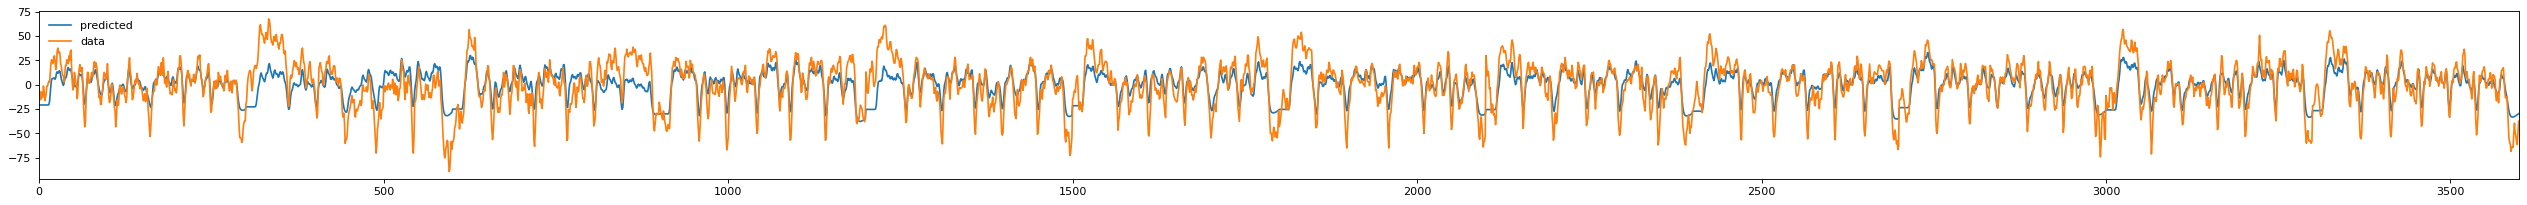

In [224]:
figure(figsize=(40, 6), dpi=80)

ax = plt.subplot(2,1,1)
ax.plot(ptcs)
ax.plot(tcs)
l = ax.legend(('predicted', 'data'),loc=2,frameon=False)
plt.xlim((0,3600))
plt.show()
